<a href="https://colab.research.google.com/github/ishandas387/Language-Model-For-Odia/blob/master/LSTM_%26_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

imports and installs thats needed


In [1]:
!pip install chart_studio
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from bs4 import BeautifulSoup
import chart_studio as cs
#import plotly.graph_objs as go
#import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot



     |████████████████████████████████| 71kB 4.1MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Check the GPU

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data

In [3]:
df = pd.read_csv('odia_news_sambad_headlines.csv')
df.tail()

,headings,label
24736,ଦିନକରେ ନିବେଶକ ହରାଇଲେ ୧.୭ ଲକ୍ଷ କୋଟି,business
24737,ସୋବିସ୍କୋ ବିସ୍କୁଟ ବିକ୍ରିରେ ୬୦% ବୃଦ୍ଧି,business
24738,ରାହୁଲଙ୍କ ସହ ଆଲୋଚନା ବେଳେ ରାଜନଙ୍କ ପରାମର୍ଶ: ଗରି...,business
24739,୨୦୨୦ ଏପ୍ରିଲ୍‌ରୁ ‘ବିଏସ୍‌-୪ କାର୍‌’ ବିକ୍ରି ବନ୍ଦ,business
24740,ଆମାଜନ୍‌ ପେ ଏବେ ଡୋମିନୋସ୍‌ରେ ଗ୍ରହଣୀୟ ହେବ,business


## Preprocessing

Cleaining, shuffling stuff

In [5]:
def to_label(label):
  label = str(label)
  if label == 'state':
    return 0
  elif label == 'sports':
    return 1
  else: 
    return 2

df['label'] = df.label.apply(to_label)
df.head()
df['label'].value_counts()

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

import string

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

def odia_num_remove(text):
  text_new = ""
  odia_num =['୦',         
  '୧',	
	'୨',	
	'୩',	
	'୪',	
	'୫',	
	'୬',	
	'୭',	
	'୮',	
	'୯',
  '‘',
  '’']
  for char in text:
    if char not in odia_num:
      text_new = text_new + char
  return text_new


,headings,label
0,"ବରଗଡ଼ରେ ଗଂଜେଇ, ସିରପ୍‌ ରାକେଟ୍‌ ଠାବ : ୭୨ କିଲୋ ଗ...",0
1,୨ଜଣ ବରିଷ୍ଠ ଓଏଏସ୍‌ଙ୍କୁ କୋଭିଡ୍‌ ହସ୍ପିଟାଲ ଦାୟିତ୍...,0
2,ଅଧ୍ୟାପକଙ୍କ ଅବସର ବୟସ ବୃଦ୍ଧିକୁ ନେଇ ମାମଲା,0
3,ଭଦ୍ରକ ବିଜେଡିର ବ୍ଲକ ଓ ପୌରାଞ୍ଚଳସ୍ତରୀୟ କର୍ମକର୍ତ...,0
4,"ଆଜି ସର୍ବାଧିକ ୩୦୪ଜଣ କରୋନା ପଜିଟିଭ୍ ଚିହ୍ନଟ, ରାଜ୍...",0


0    8980
1    8969
2    6792
Name: label, dtype: int64

In [6]:
test_string="t're is, a test! www.googfle.com\ // #test"
test_string = remove_URL(test_string)
test_string = remove_html(test_string)
print(remove_punct(test_string))

tre is a test   test


In [7]:
print(df.head(1))

                                            headings  label
0   ବରଗଡ଼ରେ ଗଂଜେଇ, ସିରପ୍‌ ରାକେଟ୍‌ ଠାବ : ୭୨ କିଲୋ ଗ...      0


In [8]:
df["headings"] = df.headings.map(lambda x: remove_URL(x))
df["headings"] = df.headings.map(lambda x: remove_html(x))
df["headings"] = df.headings.map(lambda x: remove_punct(x))
df["headings"] = df.headings.map(lambda x: odia_num_remove(x))


#Using regex with .str.findall and .str.join appears to be fastest:

#df['headings'] = df['headings'].str.findall('\w{3,}').str.join(' ')
df['headings'] = df['headings'].str.split().map(lambda sl: " ".join(s for s in sl if len(s) > 3))


df.head(10)

,headings,label
0,ବରଗଡ଼ରେ ଗଂଜେଇ ସିରପ୍‌ ରାକେଟ୍‌ କିଲୋ ଗଂଜେଇ ବୋତଲ ...,0
1,ବରିଷ୍ଠ ଓଏଏସ୍‌ଙ୍କୁ କୋଭିଡ୍‌ ହସ୍ପିଟାଲ ଦାୟିତ୍ବ ଦେଲ...,0
2,ଅଧ୍ୟାପକଙ୍କ ଅବସର ବୃଦ୍ଧିକୁ ମାମଲା,0
3,ଭଦ୍ରକ ବିଜେଡିର ବ୍ଲକ ପୌରାଞ୍ଚଳସ୍ତରୀୟ କର୍ମକର୍ତ୍ତା...,0
4,ସର୍ବାଧିକ କରୋନା ପଜିଟିଭ୍ ଚିହ୍ନଟ ରାଜ୍ୟରେ ଆକ୍ରାନ୍ତ...,0
5,ରାଜ୍ୟର ହଜାର ପୂଜକଙ୍କୁ ସହାୟତା ସୋଏମଆଇ ସଂଗଠନ ବାରି...,0
6,ପୁଅର ଦୋଷ ପାଇଁ ଦୁଆର ବର୍ଷ ହେଲା ଘରକୁ ଫେରିପାରୁ ନା...,0
7,କଟକରେ ଏସ୍‌ଆଇଟି ବୈଠକ ନିର୍ବାଚନରେ କଳାଟଙ୍କା ଉପରେ,0
8,ଆନ୍ତଃରାଜ୍ୟ ଯାତାୟତ ପାଇଁ ଜାରି ହେଲା ଗାଇଡ୍‌ଲାଇନ୍‌ ...,0
9,କରୋନା ଖୋଲୁଛି ଗୁମର ଦୁର୍ନୀତିର ଦୁର୍ନାମ କେତେ,0


In [9]:
df['label'].value_counts()

0    8980
1    8969
2    6792
Name: label, dtype: int64

In [10]:
#shuffle
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,headings,label
0,ପୂର୍ବତନ ବିଧାୟକଙ୍କ ଗାଡିକୁ ଗୁଳିମାଡ ଘଟଣା ସପ୍ତାହ ପ...,0
1,ଅନ୍ତଃଜିଲ୍ଲା କନିଷ୍ଠ ଥ୍ରୋ ବଲ୍‌ ପୁରୀକୁ ଦ୍ୱିମୁକୁଟ,1
2,ସେପ୍ଟେମ୍ବର ମିଳିବ ଗିଗା ଫାଇବର୍ ଟଙ୍କାରୁ ପ୍ଲାନ୍ ଆରମ୍ଭ,2
3,ସାଣ୍ଡିଜ୍ ଟାୱାର ପ୍ରତିଷ୍ଠାତା ସମ୍ମାନିତ,2
4,ରାଷ୍ଟ୍ରାୟତ ବ୍ୟାଙ୍କ ଉପରେ ଜରିମାନା ଲଗାଇଲା ରିଜର୍ଭ ...,2
5,ଚିନ୍ତାରେ ପୁଲିସ ଲକ୍‌ଡାଉନ୍‌ ଖିଲାପକାରୀଙ୍କୁ ଦଣ୍ଡ କ...,0
6,ଶକ୍ତିକାନ୍ତଙ୍କ ଦ୍ବିତୀୟ ଟନିକ୍ ପଶ୍ଚାତଗାମୀ ରେପୋ ହ...,2
7,କେତେ ଅଘଟଣ ସରକାର ଚେତିବେ,0
8,ବାସୁଦେବପୁର ଫୁଟ୍ ପାଣି ଟାଙ୍କି ଉପରେ ଟ୍ରାକ୍ଟର ଡ୍ରା...,0
9,ବିଏସ୍‌ଏନ୍‌ଏଲ୍‌କୁ ବଞ୍ଚାଇବାକୁ ଚାହୁଛୁ ମନ୍ତ୍ରୀ ରବି...,2


In [11]:
df['label'].value_counts()

0    8980
1    8969
2    6792
Name: label, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24741 entries, 0 to 24740
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headings  24741 non-null  object
 1   label     24741 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 386.7+ KB


In [13]:
from collections import Counter

# Count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [14]:
text = df['headings']

counter = counter_word(text)

In [15]:
len(counter)

31032

6.860514934723738

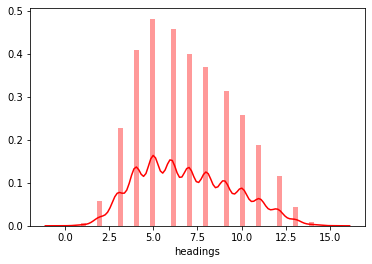

In [16]:
colum_len = df["headings"].str.len()

#this is just the string length not word count
max_value = colum_len.max()
#max_value

#word count 

word_c =  df['headings'].str.split().str.len()
word_c.mean()
sns.distplot(word_c, color='red')


## Text to sequence

In [17]:
## define word embedding props
# max number of words to keep
# embedding dimenssion
# max seq length

MAX_NB_WORDS = 15000
#the average word length of heading is taken as max seq
MAX_SEQ_LENGTH = 12
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,split=" ", oov_token='<OOV>')
tokenizer.fit_on_texts(df['headings'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens'% len(word_index))

X = tokenizer.texts_to_sequences(df['headings'].values)
X = pad_sequences(X,maxlen=MAX_SEQ_LENGTH,padding="post", truncating="post")
Y = pd.get_dummies(df['label']).values
print(Y)


Found 31033 unique tokens
[[1 0 0]
 [0 1 0]
 [0 0 1]
 ...
 [1 0 0]
 [0 0 1]
 [1 0 0]]


In [18]:
# test the sequencing # reversing

print(X[50])

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])
print(decode(X[50]))

[13113    41  1775   358  4076  5546   203  3635   953    45  2156   954]
ଇଂଲାଣ୍ଡନ୍ୟୁଜିଲାଣ୍ଡ ମୁକାବିଲା ବିଶାଳ ସ୍କୋର ଆଡକୁ ଅଗ୍ରସର ହେଉଛି ଇଂଲାଣ୍ଡ ଆଜିର ବିଜେତା ସେମିଫାଇନାଲ ଖେଳିବ


In [19]:
#building a reduced dataset for 4k records
# this is extra 
X_reduced = X[1:4000]
Y_reduced = Y[1:4000]
X_reduced.shape
Y_reduced.shape
X_reduced[7]

(3999, 12)

(3999, 3)

array([4692, 5541,  506, 3628,   20, 1772, 8784,  216,  408,    0,    0,
          0], dtype=int32)

## Split

In [20]:
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size= 0.2, random_state= 50)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(19792, 12)
(19792, 3)
(4949, 12)
(4949, 3)


In [21]:
X_train_r,X_test_r, Y_train_r, Y_test_r = train_test_split(X_reduced,Y_reduced,test_size= 0.2, random_state= 50)
print(X_train_r.shape)
print(Y_train_r.shape)
print(X_test_r.shape)
print(Y_test_r.shape)

(3199, 12)
(3199, 3)
(800, 12)
(800, 3)


# Build Model - LSTM



## Displaying history functions


In [22]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import math

In [23]:
# display the train loss graph from history
from matplotlib import pyplot

def display_history_loss(history, model_name):
  
  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])
  pyplot.title('model train vs validation loss {}'.format(model_name))
  pyplot.ylabel('loss')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')
  pyplot.show()

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  


In [24]:
def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.5
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
  return lrate


## Model 1 LSTM 
64 or node param - tanh - 0.1 dropout
Dense layer -3 - softmax




There is no final, definite, rule of thumb on how many nodes (or hidden neurons) or how many layers one should choose, and very often a trial and error approach will give you the best results for your individual problem. The most common framework for this is most likely the k-fold cross-validation. However, even for a testing procedure, we need to choose some (k) numbers of nodes.
The following formula may give you a starting point:
Image for post

![alt text](https://miro.medium.com/max/228/1*9jY98E1ndGBcob6GypYM1Q.png)

Nᵢ is the number of input neurons, Nₒ the number of output neurons, Nₛ the number of samples in the training data, and α represents a scaling factor that is usually between 2 and 10. We can calculate 8 different numbers to feed into our validation procedure and find the optimal model, based on the resulting validation loss.

In [38]:
def single_lstm(nodes, **kwargs):
  #as declared above earlier
  MAX_NB_WORDS = 15000
  EMBEDDING_DIM = 100
  MAX_SEQ_LENGTH = 12
  with tf.device('/device:GPU:0'):
    model = Sequential()

    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH))
    model.add(LSTM(nodes, activation=  kwargs.get('activation'), dropout=  kwargs.get('dropout')))
  
    model.add(Dense(3, activation= kwargs.get('dense_actv')))
    optimizer = Adam(learning_rate=1e-5)
    # Since one hot encoded. categoriacl crossentropy will work
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.summary()
    filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    # learning rate decay
    lrate = LearningRateScheduler(step_decay)
    history = model.fit(kwargs.get('X_train'),
                        kwargs.get('Y_train'), 
                        epochs= kwargs.get('epochs'), 
                        batch_size = 50,
                        callbacks= [es],
                        validation_data=(kwargs.get('X_test'),
                                         kwargs.get('Y_test')),)
    display_history_loss(history, "single_lstm")
    plot_graphs(history, "accuracy")
    score = model.evaluate(X_test, Y_test)
    print(score[0])
    print(score[1])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 12, 100)           1500000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
Total params: 1,542,435
Trainable params: 1,542,435
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 3199 samples, validate on 800 samples
Epoch 1/60
3199/3199 [==============================] - 3s 1ms/step - loss: 1.0982 - accuracy: 0.3595 - val_loss: 1.0978 - val_accuracy: 0.4025
Epoch 2/60
3199/3199 [==============================] - 3s 865us/step - loss: 1.0972 - accuracy: 0.3954 - val_loss: 1.0967 - val_accuracy: 0.4512
Epoch 3/60
3199/3199 [==============================] - 3s 853us/step - loss: 1.0959 - accuracy: 0.4292 - val_loss: 1.0957 - val_accuracy: 0.4363
Epoch 4/60
3199/3199 [==============================] - 3s 894us/step - loss: 1.0952 - accuracy: 0.4348 - val_loss: 1.0948 - val_accuracy: 0.4300
Epoch 5/60
3199/3199 [==============================] - 3s 890us/step - loss: 1.0940 - accuracy: 0.4351 - val_loss: 1.0937 - val_accuracy: 0.4175
Epoch 6/60
3199/3199 [==============================] - 3s 893us/step - loss: 1.0932 - accuracy: 0.4326 - val_loss: 1.0928 - val_accuracy: 0.4200
Epoch 7/60
3199/3199 [==============================] - 3s 894us/step - loss: 1

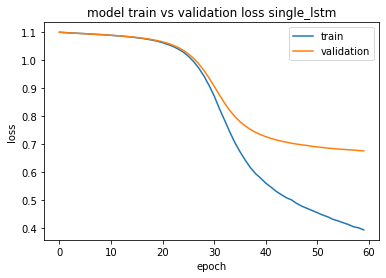

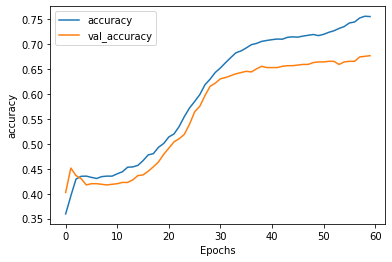

4949/4949 [==============================] - 1s 175us/step
0.5929618067851233
0.7007476091384888


In [41]:
single_lstm(64, activation = 'tanh', 
            dropout = 0.2, 
            dense_actv ='softmax',
            epochs =60,
            X_train = X_train_r,
            Y_train = Y_train_r,
            X_test = X_test_r,
            Y_test = Y_test_r)

### Result

So far the best has been noted with 64 node lstm with softmax dense activation.
100 epochs. Batch size 100. Data 19K
Validation loss on evaluate 0.7
Accuracy 0.88
Running time 599.544s


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 12, 100)           1500000   
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 1,542,435
Trainable params: 1,542,435
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 19792 samples, validate on 4949 samples
Epoch 1/100
19792/19792 [==============================] - 18s 916us/step - loss: 1.0945 - accuracy: 0.3754 - val_loss: 1.0906 - val_accuracy: 0.3920
Epoch 2/100
19792/19792 [==============================] - 18s 886us/step - loss: 1.0874 - accuracy: 0.3958 - val_loss: 1.0830 - val_accuracy: 0.4164
Epoch 3/100
19792/19792 [==============================] - 18s 888us/step - loss: 1.0787 - accuracy: 0.4238 - val_loss: 1.0718 - val_accuracy: 0.4502
Epoch 4/100
19792/19792 [==============================] - 18s 894us/step - loss: 1.0614 - accuracy: 0.4735 - val_loss: 1.0453 - val_accuracy: 0.5140
Epoch 5/100
19792/19792 [==============================] - 18s 891us/step - loss: 1.0106 - accuracy: 0.5526 - val_loss: 0.9624 - val_accuracy: 0.5872
Epoch 6/100
19792/19792 [==============================] - 18s 892us/step - loss: 0.8816 - accuracy: 0.6170 - val_loss: 0.8074 - val_accuracy: 0.6339
Epoch 7/100
19792/19792 [==========================

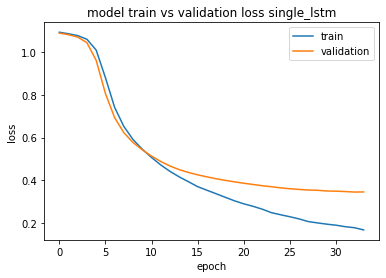

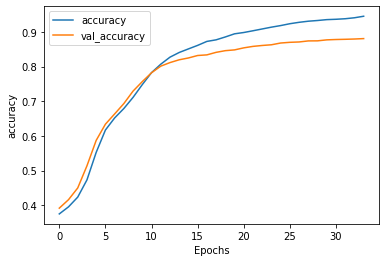

4949/4949 [==============================] - 1s 171us/step
0.34485184323741924
0.880379855632782


In [42]:
single_lstm(64, activation = 'tanh', 
            dropout = 0.2, 
            dense_actv ='softmax',
            epochs =100,
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 12, 100)           1500000   
_________________________________________________________________
lstm_12 (LSTM)               (None, 20)                9680      
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 63        
Total params: 1,509,743
Trainable params: 1,509,743
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 3199 samples, validate on 800 samples
Epoch 1/60
3199/3199 [==============================] - 3s 977us/step - loss: 1.0991 - accuracy: 0.3204 - val_loss: 1.0976 - val_accuracy: 0.3638
Epoch 2/60
3199/3199 [==============================] - 3s 865us/step - loss: 1.0983 - accuracy: 0.3348 - val_loss: 1.0967 - val_accuracy: 0.3825
Epoch 3/60
3199/3199 [==============================] - 3s 888us/step - loss: 1.0974 - accuracy: 0.3601 - val_loss: 1.0959 - val_accuracy: 0.3825
Epoch 4/60
3199/3199 [==============================] - 3s 856us/step - loss: 1.0962 - accuracy: 0.3682 - val_loss: 1.0951 - val_accuracy: 0.3862
Epoch 5/60
3199/3199 [==============================] - 3s 878us/step - loss: 1.0953 - accuracy: 0.3814 - val_loss: 1.0943 - val_accuracy: 0.3913
Epoch 6/60
3199/3199 [==============================] - 3s 857us/step - loss: 1.0944 - accuracy: 0.3904 - val_loss: 1.0936 - val_accuracy: 0.3913
Epoch 7/60
3199/3199 [==============================] - 3s 858us/step - loss:

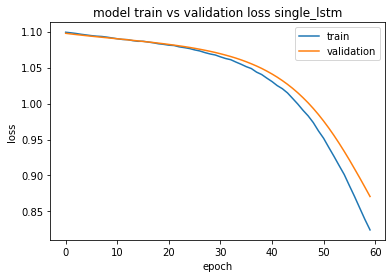

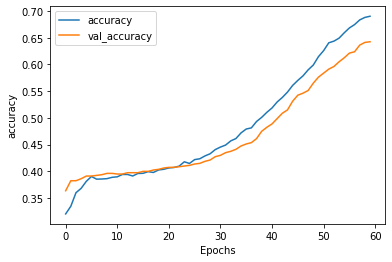

4949/4949 [==============================] - 1s 171us/step
0.8638305705733963
0.664982795715332


In [43]:
single_lstm(20, activation = 'tanh', 
            dropout = 0.25, 
            dense_actv ='softmax',
            epochs =60, 
            X_train = X_train_r,
            Y_train = Y_train_r,
            X_test = X_test_r,
            Y_test = Y_test_r)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 10, 100)           1500000   
_________________________________________________________________
lstm_26 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 195       
Total params: 1,542,435
Trainable params: 1,542,435
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 19792 samples, validate on 4949 samples
Epoch 1/50
19792/19792 [==============================] - 27s 1ms/step - loss: 0.4284 - accuracy: 0.8274 - val_loss: 0.2469 - val_accuracy: 0.9153
Epoch 2/50
19792/19792 [==============================] - 26s 1ms/step - loss: 0.1408 - accuracy: 0.9532 - val_loss: 0.2521 - val_accuracy: 0.9172
Epoch 3/50
19792/19792 [==============================] - 27s 1ms/step - loss: 0.0716 - accuracy: 0.9765 - val_loss: 0.2765 - val_accuracy: 0.9105
Epoch 4/50
19792/19792 [==============================] - 26s 1ms/step - loss: 0.0489 - accuracy: 0.9841 - val_loss: 0.3480 - val_accuracy: 0.9018
Epoch 5/50
19792/19792 [==============================] - 27s 1ms/step - loss: 0.0333 - accuracy: 0.9898 - val_loss: 0.3590 - val_accuracy: 0.9056
Epoch 6/50
19792/19792 [==============================] - 27s 1ms/step - loss: 0.0276 - accuracy: 0.9916 - val_loss: 0.4091 - val_accuracy: 0.9038
Epoch 7/50
19792/19792 [==============================] - 27s 1ms/ste

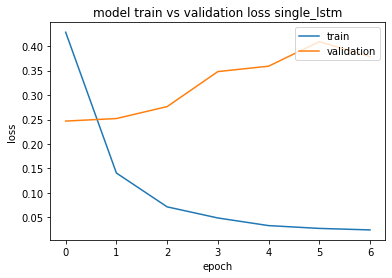

4949/4949 [==============================] - 1s 159us/step
0.3785712786357956
0.9076581001281738


In [105]:
single_lstm(64, activation = 'tanh', 
            dropout = 0.25, 
            dense_actv ='softmax',
            epochs =50, 
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 10, 100)           1500000   
_________________________________________________________________
lstm_22 (LSTM)               (None, 300)               481200    
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 903       
Total params: 1,982,103
Trainable params: 1,982,103
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 19792 samples, validate on 4949 samples
Epoch 1/20
19792/19792 [==============================] - 30s 2ms/step - loss: 0.4458 - accuracy: 0.8162 - val_loss: 0.2654 - val_accuracy: 0.9050
Epoch 2/20
19792/19792 [==============================] - 29s 1ms/step - loss: 0.1485 - accuracy: 0.9486 - val_loss: 0.2480 - val_accuracy: 0.9121
Epoch 3/20
19792/19792 [==============================] - 31s 2ms/step - loss: 0.0801 - accuracy: 0.9732 - val_loss: 0.3317 - val_accuracy: 0.9062
Epoch 4/20
19792/19792 [==============================] - 30s 2ms/step - loss: 0.0522 - accuracy: 0.9833 - val_loss: 0.3240 - val_accuracy: 0.9091
Epoch 5/20
19792/19792 [==============================] - 30s 2ms/step - loss: 0.0432 - accuracy: 0.9863 - val_loss: 0.3768 - val_accuracy: 0.8986
Epoch 6/20
19792/19792 [==============================] - 29s 1ms/step - loss: 0.0313 - accuracy: 0.9903 - val_loss: 0.3865 - val_accuracy: 0.9008
Epoch 7/20
19792/19792 [==============================] - 30s 1ms/ste

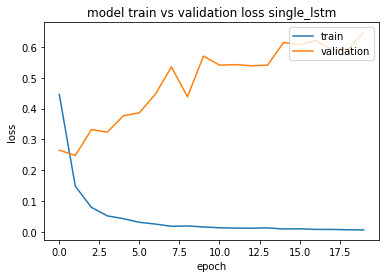

4949/4949 [==============================] - 1s 205us/step
0.6476344711593809
0.9009901285171509


In [92]:

single_lstm(300, activation = 'tanh', 
            dropout = 0.25, 
            dense_actv ='softmax',
            epochs =100, 
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test)

## Model 2 double layer LSTM 

In [85]:
def double_lstm(nodes, **kwargs):
  #as declared above earlier
  MAX_NB_WORDS = 15000
  EMBEDDING_DIM = 100
  MAX_SEQ_LENGTH = 12
  with tf.device('/device:GPU:0'):
    model = Sequential()

    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH))
    model.add(LSTM(nodes, activation=  kwargs.get('activation'), dropout=  kwargs.get('dropout'), return_sequences=True ))
    model.add(LSTM(64, activation=  kwargs.get('activation'), dropout=  kwargs.get('dropout') ))
    model.add(Dense(30,activation= kwargs.get('dense_actv')))
    model.add(Dense(3, activation= kwargs.get('dense_actv')))
    #optimizer = Adam(learning_rate=3e-4)
    # Since one hot encoded. categoriacl crossentropy will work
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    model.summary()
    history = model.fit(kwargs.get('X_train'), kwargs.get('Y_train'), epochs= kwargs.get('epochs'), validation_data=(kwargs.get('X_test'), kwargs.get('Y_test')),)
    display_history_loss(history, "double_lstm")
    score = model.evaluate(X_test, Y_test)
    print(score[0])
    print(score[1])

In [87]:
double_lstm(100, activation = 'tanh',  
            dense_actv ='softmax',
            epochs =20, 
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 12, 100)           1500000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 12, 100)           80400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_13 (Dense)             (None, 30)                1950      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 93        
Total params: 1,624,683
Trainable params: 1,624,683
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 19792 samples, validate on 4949 samples
Epoch 1/20
 7840/19792 [==========>...................] - ETA: 20s - loss: 0.9482 - accuracy: 0.6028

KeyboardInterrupt: ignored

## Model 3 bidirectional LSTM


Now we can implement LSTM. Here is my code that I build a tf.keras.Sequential model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices into sequences of vectors. After training, words with similar meanings often have the similar vectors.

Next is how to implement LSTM in code. The Bidirectional wrapper is used with a LSTM layer, this propagates the input forwards and backwards through the LSTM layer and then concatenates the outputs. This helps LSTM to learn long term dependencies. We then fit it to a dense neural network to do classification.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

In [ ]:
model2 = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 1500, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(3, activation='softmax')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1500000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 1,681,203
Trainable params: 1,681,203
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
with tf.device('/device:GPU:0'):
   history2 = model2.fit(
      X_train, Y_train, epochs=5, validation_data=(X_test, Y_test),
  )

619/619 [==============================] - 7s 11ms/step - loss: 0.4552 - accuracy: 0.8047 - val_loss: 0.2391 - val_accuracy: 0.9125
Epoch 2/5
619/619 [==============================] - 7s 11ms/step - loss: 0.1339 - accuracy: 0.9527 - val_loss: 0.2314 - val_accuracy: 0.9168
Epoch 3/5
619/619 [==============================] - 6s 10ms/step - loss: 0.0651 - accuracy: 0.9785 - val_loss: 0.2549 - val_accuracy: 0.9163
Epoch 4/5
619/619 [==============================] - 6s 10ms/step - loss: 0.0400 - accuracy: 0.9876 - val_loss: 0.2990 - val_accuracy: 0.9107
Epoch 5/5
619/619 [==============================] - 6s 10ms/step - loss: 0.0281 - accuracy: 0.9911 - val_loss: 0.3515 - val_accuracy: 0.9085


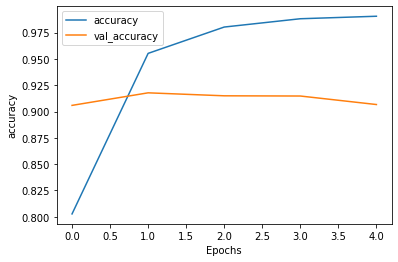

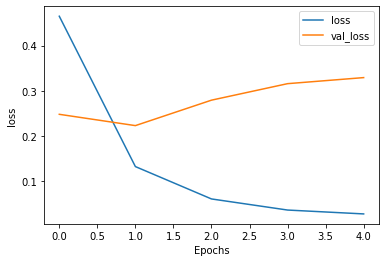

In [ ]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")  

# Build Model - Transformer


Transformer layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers as tfopt

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [46]:
maxlen = 12
vocab_size = 15000
#X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
#X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

In [47]:
X_train.shape

(19792, 12)

In [48]:
X_train[100]

array([  222,   557,   118, 12571,  2539, 12902,   161,     0,     0,
           0,     0,     0], dtype=int32)

In [54]:
embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
keras.backend.clear_session()
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(20, activation="softmax")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model_transformer = keras.Model(inputs=inputs, outputs=outputs)

## Result

100 epochs, 100 batch. 19k data training. Dense softmax activation. and extra more layer of danse 20 has given similar kind but better result achieved in LSTM model 1 with 64.

acc 0.898 - better
val_loss 0.7 - similar
runtime 204.79s - less than half of LSTM model1 

In [55]:
with tf.device('/device:GPU:0'):
  optimizer_t = tfopt.Adam(learning_rate=1e-5)
  model_transformer.compile(loss="categorical_crossentropy", optimizer=optimizer_t, metrics=["accuracy"])
  model_transformer.summary()
  history_transformer = model_transformer.fit(
      X_train, Y_train, batch_size=100, epochs=40, validation_data=(X_test, Y_test)
  )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
token_and_position_embedding (None, 12, 100)           1501200   
_________________________________________________________________
transformer_block (Transform (None, 12, 100)           47332     
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0     

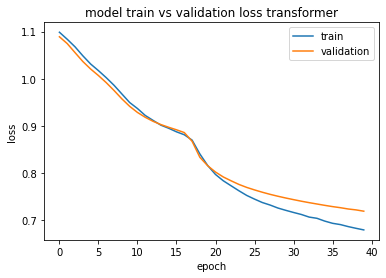

In [56]:
display_history_loss(history_transformer, "transformer")

In [57]:
print(X_test.shape)
score_transformer = model_transformer.evaluate(X_test,Y_test)
print(score_transformer[0])
print(score_transformer[1])

(4949, 12)
155/155 [==============================] - 1s 6ms/step - loss: 0.7187 - accuracy: 0.8988
0.7186862826347351
0.8987674117088318
